<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/CNN_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gradient Without Backpropagation

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tqdm
import torch.distributions as distr

In [2]:
%pip install torchmetrics --quiet

In [3]:
import torchmetrics
import torchvision
from torchvision import transforms as T
from matplotlib import pyplot as plt

Loading and preprocessing the dataset

In [4]:
#Load the dataset
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

tensor(8)


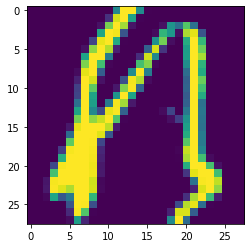

In [5]:
# This loads data with both data conversion.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=T.ToTensor())
plt.imshow(train_data.data[0])
print(train_data.targets[0])

In [6]:
# Loaders are used to shuffle, batch, and possibly sample the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

In [17]:
xb, yb = next(iter(train_loader))
xb=xb/255

In [9]:
# Loading the test data is similar, but (a) we do not apply data augmentation,
# and (b) we do not shuffle when building the mini-batches.
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

Define Convolutional Neural Network Class

In [10]:
from torch import nn
from torch.nn import functional as F

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size, conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b,):
        super().__init__()
        input_size = 1
        self.conv1 = nn.Conv2d(input_size, 8, 3, padding=1)
        self.conv1.weight = torch.nn.Parameter(conv1w)
        self.conv1.bias = torch.nn.Parameter(conv1b)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv2.weight = torch.nn.Parameter(conv2w)
        self.conv2.bias = torch.nn.Parameter(conv2b)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3.weight = torch.nn.Parameter(conv3w)
        self.conv3.bias = torch.nn.Parameter(conv3b)

        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4.weight = torch.nn.Parameter(conv4w)
        self.conv4.bias = torch.nn.Parameter(conv4b)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc1.weight = torch.nn.Parameter(fc1w)
        self.fc1.bias = torch.nn.Parameter(fc1b)

        self.fc2 = nn.Linear(1024, 10)
        self.fc2.weight = torch.nn.Parameter(fc2w)
        self.fc2.bias = torch.nn.Parameter(fc2b)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = x.reshape((-1, 64*7*7))
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
# We check if CUDA is available. If you do not see it,
# activate a GPU from Runtime >> Change runtime type and 
# restart the notebook.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Initialize the parameters

In [21]:
# We initialize the parameters randomly and the model with an input size
conv1w = torch.FloatTensor(8, 1, 3, 3).uniform_(-1, 1)
print(conv1w)
conv1b = torch.randint(-1, 1, (8, ), dtype=torch.float32, requires_grad=False)
conv2w = torch.randint(-1, 1, (16, 8, 3, 3), dtype=torch.float32, requires_grad=False)
conv2b = torch.randint(-1, 1, (16, ), dtype=torch.float32, requires_grad=False)
conv3w = torch.randint(-1, 1, (32, 16, 3, 3), dtype=torch.float32, requires_grad=False)
conv3b = torch.randint(-1, 1, (32, ), dtype=torch.float32, requires_grad=False)
conv4w = torch.randint(-1, 1, (64, 32, 3, 3), dtype=torch.float32, requires_grad=False)
conv4b = torch.randint(-1, 1, (64, ), dtype=torch.float32, requires_grad=False)
fc1w = torch.randint(-1, 1, (1024, 3136), dtype=torch.float32, requires_grad=False)
fc1b = torch.randint(-1, 1, (1024, ), dtype=torch.float32, requires_grad=False)
fc2w = torch.randint(-1, 1, (10, 1024), dtype=torch.float32, requires_grad=False)
fc2b = torch.randint(-1, 1, (10, ), dtype=torch.float32, requires_grad=False)
cnn = SimpleCNN(1, conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b).to(device)

TypeError: ignored

In [16]:
# Note: we also need to move data when asking for a prediction
print(cnn(xb.to(device))[0])

tensor([-465518.6875,  570140.6250, -489208.9375,  151515.0469,  106204.8906,
         365368.9375, -297497.2812, -262074.3906,  -21101.6289, -514078.8750],
       device='cuda:0', grad_fn=<SelectBackward0>)


Train and evaluate the network with forward gradient

In [49]:
def accuracy(net, loader, device):
  # A function that aggregates the accuracy over all mini-batches in the loader.
  # See here for a quick-start on torchmetrics: https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html.
  #acc = torchmetrics.Accuracy().to(device)
  acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = cnn(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [50]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(cnn, test_loader, device)

tensor(0.0611, device='cuda:0')

DEFINE CROSS_ENTROPY

In [51]:
# Note: it is important to move the CNN to the device before initializing the optimizer,
# since the optimizer also has a state that must be moved to the GPU.
loss = nn.CrossEntropyLoss()


In [52]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [53]:
def rosenbrock_function(x):
  sum=0
  for p in x.size():
    for i in range (x.size(1)-1):
      sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(x[i]-1, 2))
  return sum

In [54]:
from functorch import jvp

In [55]:
def train_fwd_gradient(x, y):
  x, y = x.to(device), y.to(device)
  x = x / 255

  l_rate0 = 0.025
  f = rosenbrock_function

  #Parameters
  conv1w = torch.randn((8, 1, 3, 3), requires_grad=False)
  conv1b = torch.randn(8, requires_grad=False)
  conv2w = torch.randn((16, 8, 3, 3), requires_grad=False)
  conv2b = torch.randn(16, requires_grad=False)
  conv3w = torch.randn((32, 16, 3, 3), requires_grad=False)
  conv3b = torch.randn(32, requires_grad=False)
  conv4w = torch.randn((64, 32, 3, 3), requires_grad=False)
  conv4b = torch.randn(64, requires_grad=False)
  fc1w = torch.randn((1024, 3136), requires_grad=False)
  fc1b = torch.randn(1024, requires_grad=False)
  fc2w = torch.randn((1, 1024), requires_grad=False)
  fc2b = torch.randn(1, requires_grad=False) 

  conv1w1 = conv1w.reshape(-1)
  conv2w1 = conv2w.reshape(-1)
  conv3w1 = conv3w.reshape(-1)
  conv4w1 = conv4w.reshape(-1)
  fc1w1 = fc1w.reshape(-1)
  fc2w1 = fc2w.reshape(-1)

  cnn = SimpleCNN(1, conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b).to(device)
  error = torch.norm(cnn(x)-y, 2)

  t=torch.tensor([0])

  while (error>1e-3) :

    t=t+1

    vconv1w1=torch.diagonal(torch.normal(torch.zeros_like(conv1w1),torch.eye(conv1w1.shape[0])))
    vconv1b=torch.diagonal(torch.normal(torch.zeros_like(conv1b),torch.eye(conv1b.shape[0])))
    vconv2w1=torch.diagonal(torch.normal(torch.zeros_like(conv2w1),torch.eye(conv2w1.shape[0])))
    vconv2b=torch.diagonal(torch.normal(torch.zeros_like(conv2b),torch.eye(conv2b.shape[0])))
    vconv3w1=torch.diagonal(torch.normal(torch.zeros_like(conv3w1),torch.eye(conv3w1.shape[0])))
    vconv3b=torch.diagonal(torch.normal(torch.zeros_like(conv3b),torch.eye(conv3b.shape[0])))
    vconv4w1=torch.diagonal(torch.normal(torch.zeros_like(conv4w1),torch.eye(conv4w1.shape[0])))
    vconv4b=torch.diagonal(torch.normal(torch.zeros_like(conv4b),torch.eye(conv4b.shape[0])))
    vfc1w1=torch.diagonal(torch.normal(torch.zeros_like(fc1w1),torch.eye(fc1w1.shape[0])))
    vfc1b=torch.diagonal(torch.normal(torch.zeros_like(fc1b),torch.eye(fc1b.shape[0])))
    vfc2w1=torch.diagonal(torch.normal(torch.zeros_like(fc2w1),torch.eye(fc2w1.shape[0])))
    vfc2b=torch.diagonal(torch.normal(torch.zeros_like(fc2b),torch.eye(fc2b.shape[0])))

    ftconv1w1=f(conv1w1)
    ftconv1b=f(conv1b)
    ftconv2w1=f(conv2w1)
    ftconv2b=f(conv2b)
    ftconv3w1=f(conv3w1)
    ftconv3b=f(conv3b)
    ftconv4w1=f(conv4w1)
    ftconv4b=f(conv4b)
    ftfc1w1=f(fc1w1)
    ftfc1b=f(fc1b)
    ftfc2w1=f(fc2w1)
    ftfc2b=f(fc2b)

    dtconv1w1=torch.tensor(jvp(f,(conv1w1, ), (vconv1w1, ))[1])
    dtconv1b=torch.tensor(jvp(f,(conv1b, ), (vconv1b, ))[1])
    dtconv2w1=torch.tensor(jvp(f,(conv2w1, ), (vconv2w1, ))[1])
    dtconv2b=torch.tensor(jvp(f,(conv2b, ), (vconv2b, ))[1])
    dtconv3w1=torch.tensor(jvp(f,(conv3w1, ), (vconv3w1, ))[1])
    dtconv3b=torch.tensor(jvp(f,(conv3b, ), (vconv3b, ))[1])
    dtconv4w1=torch.tensor(jvp(f,(conv4w1, ), (vconv4w1, ))[1])
    dtconv4b=torch.tensor(jvp(f,(conv4b, ), (vconv4b, ))[1])
    dtfc1w1=torch.tensor(jvp(f,(fc1w1, ), (vfc1w1, ))[1])
    dtfc1b=torch.tensor(jvp(f,(fc1b, ), (vfc1b, ))[1])
    dtfc2w1=torch.tensor(jvp(f,(fc2w1, ), (vfc2w1, ))[1])
    dtfc2b=torch.tensor(jvp(f,(fc2b, ), (vfc2b, ))[1])

    gtconv1w1 = vconv1w1*dtconv1w1
    gtconv1b = vconv1b*dtconv1b
    gtconv2w1 = vconv2w1*dtconv2w1
    gtconv2b = vconv2b*dtconv2b
    gtconv3w1 = vconv3w1*dtconv3w1
    gtconv3b = vconv3b*dtconv3b
    gtconv4w1 = vconv4w1*dtconv4w1
    gtconv4b = vconv4b*dtconv4b
    gtfc1w1 = vfc1w1*dtfc1w1
    gtfc1b = vfc1b*dtfc1b
    gtfc2w1 = vfc2w1*dtfc2w1
    gtfc2b = vfc2b*dtfc2b

    conv1w1 -= l_rate0*gtconv1w1
    conv1b -= l_rate0*gtconv1b
    conv2w1 -= l_rate0*gtconv2w1
    conv2b -= l_rate0*gtconv2b
    conv3w1 -= l_rate0*gtconv3w1
    conv3b -= l_rate0*gtconv3w1
    conv4w1 -= l_rate0*gtconv4w1
    conv4b -= l_rate0*gtconv4b
    fc1w1 -= l_rate0*gtfc1w1
    fc1b -= l_rate0*gtfc1b
    fc2w1 -= l_rate0*gtfc2w1
    fc2b -= l_rate0*gtfc2b

    conv1w = conv1w1.reshape(-1, 1, 3, 3)
    conv2w = conv2w1.reshape(-1, 8, 3, 3)
    conv3w = conv3w1.reshape(-1, 16, 3, 3)
    conv4w = conv4w1.reshape(-1, 32, 3, 3)
    fc1w = fc1w1.reshape(-1, 3136)
    fc2w = fc2w1.reshape(-1, 1024)

    cnn = SimpleCNN(1, conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b).to(device)
    error = torch.norm(cnn(x)-y, 2)

  return conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b 

In [ ]:
for epoch in range(1):

  cnn.train()
  for i in range(1):
    xb, yb = next(iter(train_loader))
    xb = xb.to(device)
    yb = yb.to(device)

    conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b = train_fwd_gradient(xb, yb)
    cnn = SimpleCNN(1, conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b).to(device)

    #Update cnn parameters
    #Recalculate ypred and loss
    #MIRAR NN_LAB_LOGISITC_REGRESSION
    #CALCULAR G(THETA) QUE ES EL GRADIENTE Y APLICARLO A LOS PARAMETROS DEL CNN, LOS WEIGHTS